In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import seaborn as sns
import os
import os.path as osp
import sys
import pickle
import joblib
from collections import Counter
from itertools import product
import torch
import pdb
import random
import tables
from sklearn.linear_model import LogisticRegression, LinearRegression
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, average_precision_score,\
balanced_accuracy_score
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.calibration import CalibratedClassifierCV
import wandb
from wandb.lightgbm import wandb_callback, log_summary
from dill.source import getsource
from dill import detect
import functools
from copy import deepcopy

### set the seeds and change to current directory + set the output directory

In [2]:
SEED=90210
np.random.seed(SEED)
os.environ['USER_PATH']='/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/'
os.environ['OUT_PATH']='/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/output_directory'

In [3]:
os.chdir('/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/')
from AnalysisFuncs import trainEvalModel, trainHardPseudo, secondStageDataGen
from AnalysisFuncs import saveFile, loadFile, getClippedProbs, plotCalibrationPlots

In [4]:
%reload_ext autoreload
%autoreload 2

### Create function to pickle functions

In [5]:
def function_to_string(fn):
    return getsource(detect.code(fn)) 

In [6]:
processed_data_path=osp.join(os.environ.get('OUT_PATH'), 'ParksInspection', 'New_Dataset')

In [7]:
test_X = loadFile(osp.join(processed_data_path,'predict_T'), '/test_X.npy')

In [8]:
test_idxs = loadFile(processed_data_path, '/test_idxs.npy')
train_idxs = loadFile(processed_data_path, '/train_idxs.npy')
val_idxs = loadFile(processed_data_path, '/val_idxs.npy')
df_cleaned = loadFile(processed_data_path, 'df_cleaned.csv')
assert len(np.intersect1d(train_idxs, val_idxs))==0
assert len(np.intersect1d(test_idxs, val_idxs))==0
assert len(np.intersect1d(train_idxs, test_idxs))==0
tr=len(train_idxs)
v=len(val_idxs)
t=len(test_idxs)
print(f"train %:{tr*100/(tr+v+t):.2f}, val %:{v*100/(tr+v+t):.2f}, test %:{t*100/(tr+v+t):.2f}")

train %:64.01, val %:15.99, test %:19.99


/home/rr568/.conda/envs/icu-benchmark/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if await self.run_code(code, result, async_=asy):


In [9]:
calibrate_method='sigmoid'
calibrated_p_T = loadFile(osp.join(processed_data_path, calibrate_method, 'probs_T'), '/probs.npy')
calibrated_p_D_T1 = loadFile(osp.join(processed_data_path, calibrate_method, 'probs_D|T'), '/probs.npy')

41941


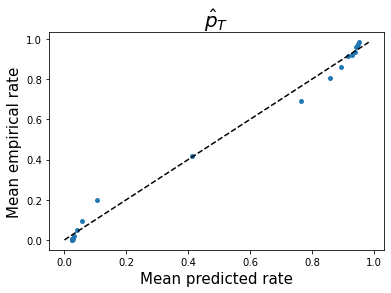

In [10]:
# check that these are indeed the calibrated probabilities 
fig1,ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
test_y_T = loadFile(osp.join(processed_data_path,'predict_T'), '/test_y_T.npy')
plotCalibrationPlots(calibrated_p_T, test_y_T, None, 'T', ax1, ax2, n_bins=20)
fig1.show()
fig2.show()
plt.close()
print(len(test_y_T))

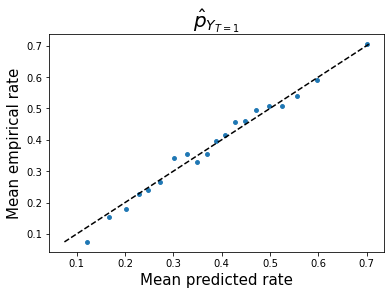

In [11]:
fig1,ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
test_y_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'), '/test_y_D_given_T.npy')
plotCalibrationPlots(calibrated_p_D_T1[test_y_T==1], test_y_D_given_T, None, 'D|T', ax1, ax2, n_bins=20)
fig1.show()
fig2.show()
plt.close()

In [12]:
train_second_stage, test_second_stage, _ = secondStageDataGen(test_idxs,
            calibrated_p_T.copy(), calibrated_p_D_T1.copy(), train_size=0.5, dataset="inspections", df=df_cleaned)
assert np.isnan(train_second_stage['D'][train_second_stage['T']==0]).all()
assert np.isnan(test_second_stage['D'][test_second_stage['T']==0]).all()
assert not np.isnan(train_second_stage['D'][train_second_stage['T']==1]).any()
assert not np.isnan(test_second_stage['D'][test_second_stage['T']==1]).any()

For Inspections dataset
0.5006795260008102 405
20999 20942 41941


/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/AnalysisFuncs.py:683: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[groupName]=df[groupName].apply(lambda x: "UNK" if x!=x else x)


In [13]:
np.isnan(train_second_stage['D'][train_second_stage['T']==1]).all()

False

In [14]:
train_second_stage

{'idxs': array([    4,     5,     8, ..., 41937, 41939, 41940]),
 'T': array([1, 1, 0, ..., 0, 1, 0]),
 'D': array([ 1.,  1., nan, ..., nan,  0., nan]),
 'D_and_T': array([1, 1, 0, ..., 0, 0, 0])}

In [15]:
test_X_copy=test_X.copy()
train_second_stage['X_T'] = test_X_copy[train_second_stage['idxs'],:]
train_second_stage['X_D_T1'] = test_X_copy[train_second_stage['idxs'],:][train_second_stage['T']==1,:]
train_second_stage['D_T1'] = train_second_stage['D'][train_second_stage['T']==1].astype(int)
test_second_stage['X_T'] = test_X_copy[test_second_stage['idxs'],:]
test_second_stage['X_D_T1'] = test_X_copy[test_second_stage['idxs']][test_second_stage['T']==1,:]
test_second_stage['D_T1'] = test_second_stage['D'][test_second_stage['T']==1].astype(int)

In [16]:
print("for test train set")
print(f"T % :{len(train_second_stage['T'][train_second_stage['T']==1])/len(train_second_stage['T'])}")
print(f"D_T1 % :{len(train_second_stage['D_T1'][train_second_stage['D_T1']==1])/len(train_second_stage['D_T1'])}")
print(f"D_and_T % :{len(train_second_stage['D_and_T'][train_second_stage['D_and_T']==1])/len(train_second_stage['T'])}")
print("for test test set")
print(f"T % :{len(test_second_stage['T'][test_second_stage['T']==1])/len(test_second_stage['T'])}")
print(f"D_T1 % :{len(test_second_stage['D_T1'][test_second_stage['D_T1']==1])/len(test_second_stage['D_T1'])}")
print(f"D_and_T % :{len(test_second_stage['D_and_T'][test_second_stage['D_and_T']==1])/len(test_second_stage['T'])}")

for test train set
T % :0.5012143435401686
D_T1 % :0.3888836104513064
D_and_T % :0.19491404352588218
for test test set
T % :0.48686849393563175
D_T1 % :0.3740682620635543
D_and_T % :0.1821220513800019


In [17]:
# load the best params as pickle if they exist , if not use the default settings
random_state=0
bst_params_T_LGBM={'random_state': random_state, 
                  }
LGBM_T = LGBMClassifier(**bst_params_T_LGBM)
bst_params_D_given_T_LGBM = {'bagging_fraction': 0.9834006751148752, 
             'feature_fraction': 0.7609241608750359, 'max_depth': 7, 'min_child_samples': 50}
LGBM_D_given_T = LGBMClassifier(**bst_params_D_given_T_LGBM)
LGBM_D_given_T_ipw = LGBMClassifier(**bst_params_D_given_T_LGBM)
bst_params_D_and_T_LGBM={'random_state': random_state, 
                  }
LGBM_D_and_T = LGBMClassifier(**bst_params_D_and_T_LGBM)
calibrate_method='sigmoid'

In [18]:
processed_data_path

'/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/output_directory/ParksInspection/New_Dataset'

In [19]:
#save models
saveFile(osp.join(processed_data_path,'secondStage'), train_second_stage, 'train_second_stage.pkl')
saveFile(osp.join(processed_data_path,'secondStage'), test_second_stage, 'test_second_stage.pkl')

In [20]:
model_descr="predicting T using LGBM for second stage"
LGBM_T, test_proba_LGBM_T = trainEvalModel(LGBM_T, train_second_stage['X_T'], train_second_stage['T'], 
                                           test_second_stage['X_T'], test_second_stage['T'], 
                                       model_descr, calibrate=True, calibrate_method=calibrate_method)

AUC score :predicting T using LGBM for second stage: 0.946
AUPR score :predicting T using LGBM for second stage: 0.923


In [21]:
saveFile(osp.join(processed_data_path, 'secondStage','predict_T'), LGBM_T, 'LGBM_T.pkl')

In [22]:
model_descr="predicting D|T using LGBM for second stage"
LGBM_D_given_T, test_proba_LGBM_D_given_T = trainEvalModel(LGBM_D_given_T, train_second_stage['X_D_T1'], 
                    train_second_stage['D_T1'], test_second_stage['X_D_T1'], 
                                            test_second_stage['D_T1'],
                                            model_descr, calibrate=True, calibrate_method=calibrate_method)

[LightGBM] [Warning] bagging_fraction is set=0.9834006751148752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9834006751148752
[LightGBM] [Warning] feature_fraction is set=0.7609241608750359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7609241608750359
[LightGBM] [Warning] bagging_fraction is set=0.9834006751148752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9834006751148752
[LightGBM] [Warning] feature_fraction is set=0.7609241608750359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7609241608750359
[LightGBM] [Warning] bagging_fraction is set=0.9834006751148752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9834006751148752
[LightGBM] [Warning] feature_fraction is set=0.7609241608750359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7609241608750359
[LightGBM] [Warning] bagging_fraction is set=0.9834006751148752, subsample=1.0 will be ignored. C

In [23]:
model_descr="predicting D,T using LGBM for second stage"
LGBM_D_and_T, test_proba_LGBM_D_and_T = trainEvalModel(LGBM_D_and_T, train_second_stage['X_T'], 
                    train_second_stage['D_and_T'], test_second_stage['X_T'],
                                        test_second_stage['D_and_T'],
                                        model_descr, calibrate=True, calibrate_method=calibrate_method)

AUC score :predicting D,T using LGBM for second stage: 0.833
AUPR score :predicting D,T using LGBM for second stage: 0.454


In [ ]:
model_descr="predicting D|T_IPW using LGBM for second stage"
train_X_D_given_T_probs_LGBM, train_cross_val_X_ipw = getClippedProbs(LGBM_T, train_second_stage['X_T'], train_second_stage['T'] )
assert np.allclose(train_cross_val_X_ipw, train_second_stage['X_D_T1'])
LGBM_D_given_T_ipw, test_proba_LGBM_D_given_T_ipw = trainEvalModel(LGBM_D_given_T_ipw, train_cross_val_X_ipw.copy(), 
        train_second_stage['D_T1'], test_second_stage['X_D_T1'], test_second_stage['D_T1'],
        model_descr, calibrate=True, sample_weight=1/train_X_D_given_T_probs_LGBM, calibrate_method=calibrate_method)

In [25]:

saveFile(osp.join(processed_data_path, 'secondStage', 'predict_D_given_T'), LGBM_D_given_T, 'LGBM_D_given_T.pkl')
saveFile(osp.join(processed_data_path, 'secondStage', 'predict_D_and_T'), LGBM_D_and_T, 'LGBM_D_and_T.pkl')
saveFile(osp.join(processed_data_path, 'secondStage', 'predict_D_given_T_ipw'), LGBM_D_given_T_ipw, 'LGBM_D_given_T_ipw.pkl')

#### Hard PseudoLabels

In [26]:
random_state=0
bst_params_D_pseudo_LGBM = bst_params_D_given_T_LGBM
LGBM_D_pseudo = LGBMClassifier(**bst_params_D_pseudo_LGBM)

In [27]:
LGBM_D_pseudo, test_probs_D_pseudo_LGBM = trainHardPseudo(deepcopy(LGBM_D_given_T), None, None, None,
        train_second_stage['X_T'], None, deepcopy(LGBM_D_given_T), test_second_stage['X_D_T1'].copy(),
                                                          test_second_stage['D_T1'].copy(), 
        model_descr="LGBM with hard pseudo labels for second stage", calibrate=False, 
        train_y_D=train_second_stage['D'].copy())


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
no val data was passed
[LightGBM] [Warning] bagging_fraction is set=0.9834006751148752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9834006751148752
[LightGBM] [Warning] feature_fraction is set=0.7609241608750359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7609241608750359
[LightGBM] [Warning] bagging_fraction is set=0.9834006751148752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9834006751148752
[LightGBM] [Warning] feature_

In [28]:
train_second_stage['D'][train_second_stage['D']==np.nan]

array([], dtype=float64)

In [29]:
train_second_stage['D'][train_second_stage['T']==0]

array([nan, nan, nan, ..., nan, nan, nan])

In [30]:
saveFile(osp.join(processed_data_path,'secondStage', 'predict_D_pseudo'), LGBM_D_pseudo, 'LGBM_D_pseudo.pkl')